### importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### Load data and preproccess data (Same as assignment 1)

In [2]:
da_prices=pd.read_csv("Spot_Prices.xls",parse_dates=['ts'])

start_date='2022-02-01'
end_date='2022-11-10'

da_prices=da_prices[(da_prices['ts']>start_date) & (da_prices['ts']<end_date)]

da_prices.set_index('ts',inplace=True)
da_prices=da_prices.resample('h').ffill()
da_prices.reset_index('ts',inplace=True)

# Convert price column to numeric (replace ',' with '.')
price_column = 'Nordpool Elspot Prices - hourly price DK-DK2 EUR/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_eur | 3038'
da_prices[price_column] = da_prices[price_column].str.replace(',', '.').astype(float)

## Plot of price

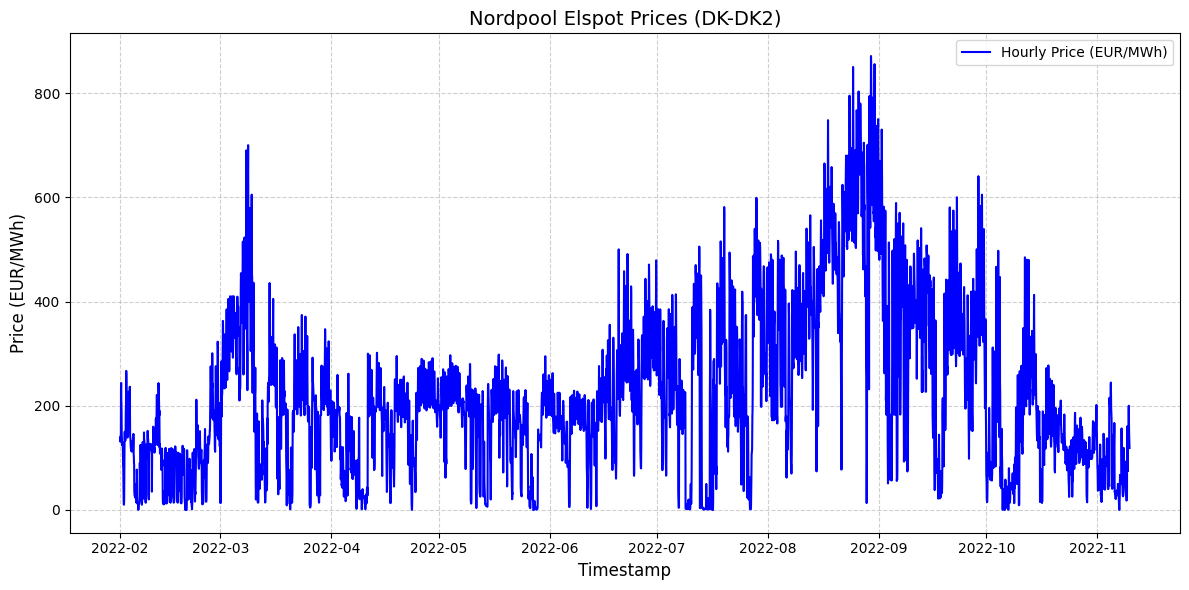

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(da_prices['ts'], da_prices[price_column], label='Hourly Price (EUR/MWh)', color='blue')

plt.title('Nordpool Elspot Prices (DK-DK2)', fontsize=14)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Price (EUR/MWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### Class for battery

In [22]:
class BatteryEmulator:
    def __init__(self, price_threshold=50, charge_discharge_rate=0.2, soc_max=1.0):
        """
        Initialize the BatteryEmulator with default parameters.
        :param price_threshold: Threshold for price categorization (High/Low).
        :param charge_discharge_rate: Rate of charging/discharging per hour.
        :param soc_max: Maximum state of charge (SOC).
        """
        
        # If we want dynamic price signal this has to change
        self.price_threshold = price_threshold 
        self.charge_discharge_rate = charge_discharge_rate
        self.soc_max = soc_max
        self.actions = ["Charge", "Discharge", "Idle"]
        self.soc_states = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

    def calculate_price_signal(self, price):
        """
        Categorize price as High (H) or Low (L).
        :param price: Electricity price.
        :return: "H" if price > threshold, otherwise "L".
        """
        return "H" if price > self.price_threshold else "L"

    def simulate_battery(self, SoC, action):
        """
        Simulate the battery's behavior for a given action.
        :param SoC: Current state of charge.
        :param action: Action to perform ("Charge", "Discharge", "Idle").
        :return: New state of charge.
        """
        if action == "Charge":
            return min(SoC + self.charge_discharge_rate, self.soc_max)
        elif action == "Discharge":
            return max(SoC - self.charge_discharge_rate, 0)
        else:  # Idle
            return SoC

    def generate_state_transitions(self, prices):
        """
        Generate state transitions based on SOC states, actions, and prices.
        :param prices: Array of electricity prices.
        :return: List of state transitions [(current_state, action, next_state)].
        """
        state_transitions = []

        # For all soc-states, taking every actions, and at every price
        # determine the next state
        for current_SOC in self.soc_states:
            for action in self.actions:
                for t in range(len(prices) - 1):
                    
                    # Current price
                    price = prices[t]
                    # Price signal based on current price
                    price_signal = self.calculate_price_signal(price)
                    
                    # Current state based on soc and price signal 
                    current_state = (current_SOC, price_signal)

                    # Handles charge and discharge at max resp min soc, stay in same state since invalid
                    # What about price signal here?
                    if (action == "Charge" and current_SOC >= self.soc_max) or (
                        action == "Discharge" and current_SOC <= 0):
                        next_state = current_state
                        
                    # If not at max or min, get next soc based on action and next price signal for next state
                    else:
                        next_SOC = self.simulate_battery(current_SOC, action)
                        next_price = prices[t + 1]
                        next_price_signal = self.calculate_price_signal(next_price)
                        next_state = (next_SOC, next_price_signal)

                    # Add next state to state transitions
                    state_transitions.append((current_state, action, next_state))

        return state_transitions

    def count_and_calculate_probabilities(self, state_transitions):
        """
        Calculate transition probabilities from state transitions.
        Ensures invalid actions (e.g., discharging at SOC=0 or charging at SOC=1.0) have probabilities of 0.
    
        :param state_transitions: List of transitions [(current_state, action, next_state)].
        :return: Dictionary of transition probabilities.
        """
        # To store number of times a state-action leads to a next_state
        transition_counts = defaultdict(lambda: defaultdict(int))
        transition_probs = {}

        # counts times action in current_state leads to next_state
        for current_state, action, next_state in state_transitions:
            transition_counts[(current_state, action)][next_state] += 1

        # Calc total amont of times a action was taken in current_state
        for (current_state, action), counts in transition_counts.items():
            total = sum(counts.values())
            transition_probs[(current_state, action)] = {}

            for next_state, count in counts.items():
                
                # Check if invalid action, if so, prob = 0
                if (action == "Discharge" and current_state[0] == 0) or (
                    action == "Charge" and current_state[0] == self.soc_max):
                    transition_probs[(current_state, action)][next_state] = 0
                    
                # If valid action, calc prob
                else:
                    transition_probs[(current_state, action)][next_state] = count / total

        return transition_probs


### Function to format transistion matrix

In [21]:
def format_transition_matrix(transition_probs):
    """
    Format transition probabilities into a DataFrame.
    :param transition_probs: Dictionary of transition probabilities.
    :return: Formatted DataFrame.
    """
    rows = []

    for (current_state, action), next_states in transition_probs.items():
        readable_state = (round(float(current_state[0]), 1), current_state[1])

        for next_state, prob in next_states.items():
            readable_next_state = (round(float(next_state[0]), 1), next_state[1])
            rows.append({
                "Current State-Action": f"{readable_state}-{action}",
                "Next State": readable_next_state,
                "Probability": prob
            })

    df = pd.DataFrame(rows)
    pivot_df = df.pivot(
        index="Current State-Action",
        columns="Next State",
        values="Probability"
    ).fillna(0)

    return pivot_df


### Value iteration

In [20]:
class ValueIteration:
    def __init__(self, gamma=1.0, epsilon=1e-6):
        """
        Initialize the ValueIteration algorithm.
        :param gamma: Discount factor for future rewards.
        :param epsilon: Convergence threshold.
        """
        self.gamma = gamma
        self.epsilon = epsilon

    def run(self, transition_probs, rewards):
        """
        Perform value iteration to find the optimal value function and policy.
        :param transition_probs: Transition probabilities as a dictionary.
        :param rewards: Rewards for each (state, action).
        :return: Optimal value function V and policy.
        """
        states = list(set([state for state, _ in transition_probs.keys()]))
        actions = list(set([action for _, action in transition_probs.keys()]))

        # Initialize value function and policy
        V = {state: 0 for state in states}
        policy = {state: None for state in states}

        while True:
            delta = 0
            V_new = V.copy()

            for state in states:
                action_values = []
                for action in actions:
                    if (state, action) in transition_probs:
                        value = rewards[(state, action)] + self.gamma * sum(
                            prob * V[next_state]
                            for next_state, prob in transition_probs[(state, action)].items()
                        )
                        action_values.append((value, action))

                if action_values:
                    best_value, best_action = max(action_values)
                    V_new[state] = best_value
                    policy[state] = best_action

                delta = max(delta, abs(V_new[state] - V[state]))

            V = V_new
            if delta < self.epsilon:
                break

        return V, policy


In [23]:
# Initialize the BatteryEmulator
battery_emulator = BatteryEmulator(price_threshold=50, charge_discharge_rate=0.2, soc_max=1.0)

# Example data: electricity prices
prices = da_prices[price_column].values

# Generate state transitions
state_transitions = battery_emulator.generate_state_transitions(prices)

# Calculate transition probabilities
transition_probs = battery_emulator.count_and_calculate_probabilities(state_transitions)

transition_matrix = format_transition_matrix(transition_probs)
print(transition_matrix)

# Save transition matrix to CSV
transition_matrix.to_csv("transition_matrix.csv")


Next State            (0.0, H)  (0.0, L)  (0.2, H)  (0.2, L)  (0.4, H)  \
Current State-Action                                                     
(0.0, 'H')-Charge     0.000000  0.000000  0.980176  0.019824  0.000000   
(0.0, 'H')-Discharge  0.000000  0.000000  0.000000  0.000000  0.000000   
(0.0, 'H')-Idle       0.980176  0.019824  0.000000  0.000000  0.000000   
(0.0, 'L')-Charge     0.000000  0.000000  0.135417  0.864583  0.000000   
(0.0, 'L')-Discharge  0.000000  0.000000  0.000000  0.000000  0.000000   
(0.0, 'L')-Idle       0.135417  0.864583  0.000000  0.000000  0.000000   
(0.2, 'H')-Charge     0.000000  0.000000  0.000000  0.000000  0.980176   
(0.2, 'H')-Discharge  0.980176  0.019824  0.000000  0.000000  0.000000   
(0.2, 'H')-Idle       0.000000  0.000000  0.980176  0.019824  0.000000   
(0.2, 'L')-Charge     0.000000  0.000000  0.000000  0.000000  0.135417   
(0.2, 'L')-Discharge  0.135417  0.864583  0.000000  0.000000  0.000000   
(0.2, 'L')-Idle       0.000000  0.0000